In [0]:
import numpy as np
import pandas as pd 
import os 
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold 
from sklearn import svm, metrics, linear_model
from sklearn.naive_bayes import GaussianNB

from google.colab import drive
drive.mount('/content/gdrive', )

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from keras.layers import Input, Dense 
from keras.models import Model 

Using TensorFlow backend.


## I. Baselines and data processing

In [0]:
G_x = open('gdrive/My Drive/data/bgedv2_X_tr_float64.npy', 'rb')
G_y = open('gdrive/My Drive/data/bgedv2_Y_tr_0-4760_float64.npy', 'rb')
G_x = np.load(G_x, encoding='latin1')
G_y = np.load(G_y, encoding='latin1')

## So what is going on in these tables?
### X matrix
* G_x: 88 807 expression profiles reporting the expression of 943 **landmark genes**
* We do not need to change this to bring the problem down to one target gene, this is simply the features our model is going to use!
* We'll have 88 807 values for target gene expressions, representing the expression of T1 for each of these profiles.


In [0]:
'''
Variance of G_x

Here we have 88 807 profiles based on 943 landmark genes.
Each row is an example of a sequence of landmark expression
'''
print(G_x.shape)
print("Target expression values:\n\tMedian: {}\n\tMean: {}\n\tVariance: {}".format(np.median(G_x),
                                                                                    np.mean(G_x),
                                                                                   np.var(G_x)))                                                                         

(88807, 943)
Target expression values:
	Median: -0.0416791179344651
	Mean: 0.00027861079062735443
	Variance: 0.9979830159508396


### Y vector
* G_y is a 88 807 columns by 4760 rows matrix
* Each individual tile is one expression value for one of the target genes, corresponding to one of the landmark profiles from the X variable

* What we want to extract is **column 1**:
  * column 1 is 88 807 samples of the expression value of target gene 1
  * each row is the expression value of the target gene for the corresponding profile described in X


In [0]:
'''This holds 88 807 expression profiles for our T1 gene

In other word, each row the expression of gene T1 for one 88807 combinations
we have in the X vector. the "Price of my house"
'''

print(G_y.shape)
print(type(G_y))


#Here we have the expression of 4760 target genes for each of the 88807 profiles
#    - Each column is the expression value for one of the 4760 target genes
#    - Each row corresponds to one of the expression profile described in X

T1_y = G_y[:30000,0]
print(T1_y.shape)
#print("Target expression values:\n\tMedian: {}\n\tMean: {}\n\tVariance: {}".format(np.median(T1_y),
                                                                                  #np.mean(T1_y),
                                                                                  #np.var(T1_y)))
    
G_x_new = G_x[:30000,:]
T1_y = G_y[:30000,0]
print(T1_y.shape)

(88807, 4760)
<class 'numpy.ndarray'>
(30000,)
(30000,)


So in conclusion
* G_x: 8807 x 943, that is 88k samples, each with 943 features
* T1_y: 8807 x 1, 88807 expression values of T1, one for each sample

We can now throw all the usual classifiers at this and hope for the best! :) :) 

In [0]:
# splitting the samples into 80:10:10 
G_x_train, x_left, G_y_train, y_left = train_test_split(G_x_new, T1_y, test_size=0.2, random_state=42)
G_x_valid, G_x_test, G_y_valid, G_y_test = train_test_split(x_left, y_left, test_size=0.5, random_state=42)


# Feature Selection  - PCA


In [0]:
from sklearn.preprocessing import StandardScaler 



'''
Normalizing the datas set, applying PCA
'''

scaler = StandardScaler() 
scaler.fit(G_x_train)

G_x_train1 = scaler.transform(G_x_train)
G_x_valid1 = scaler.transform(G_x_valid)
G_x_test1 = scaler.transform(G_x_test)


# fitting PCA on training set only 
from sklearn.decomposition import PCA
pca = PCA(0.95)
pca.fit(G_x_train1)
pca.n_components_

train = pca.transform(G_x_train1)
valid = pca.transform(G_x_valid1)
test = pca.transform(G_x_test1)
np.save("train_pca.npy", train)
np.save("valid_pca.npy", valid)
np.save("test_pca.npy", test)
#print ("train Shape: {}".format(train.shape))
#print ("valid Shape: {}".format(valid.shape))
#print ("test Shape: {}".format(test.shape))

print(G_y_train.shape)
print(G_y_valid.shape)

(24000,)
(3000,)


In [0]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt 

'''
SVM Baseline, MAE reporting
'''

Penalty = np.linspace(0.1,1,10)
# SVM 
def SVM(x_train, y_train, x_test, G_y_valid):
    predicted_svm = []
    expected = G_y_valid
    for i in Penalty: 
      print("C Value", i)
      sv = svm.SVR(C=i)
      sv.fit(x_train,y_train)
      predicted_svr = sv.predict(x_test)
      MAE = metrics.mean_absolute_error(expected, predicted_svr)
      print ("Mean absolute error",MAE)
      predicted_svm.append(predicted_svr)
      plt.plot(i,MAE,'o')
    plt.xlabel("C value")
    plt.ylabel("Validation MAE")
    plt.title("C value v.s Validation MAE")
    plt.show()
    return predicted_svm
 

predicted_svm = SVM(train, G_y_train, test, G_y_test)
#print ("Mean absolute error",(metrics.mean_absolute_error(expected, predicted_svm)))
#print ("MSE: {}".format(metrics.mean_squared_error(expected, predicted_svm)))

C Value 0.1


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [0]:
'''
Load and process the GTE dataset
'''


train = np.load("train_pca.npy", encoding='latin1')
valid = np.load("valid_pca.npy", encoding='latin1')
test = np.load("test_pca.npy", encoding='latin1')
GTE_x = open('gdrive/My Drive/data/GTEx_X_float64.npy', 'rb')
GTE_y = open('gdrive/My Drive/data/GTEx_Y_0-4760_float64.npy', 'rb')
g_x = open('gdrive/My Drive/data/1000G_X_float64.npy', 'rb')
g_y = open('gdrive/My Drive/data/1000G_Y_0-4760_float64.npy', 'rb')

GTE_x = np.load(GTE_x, encoding='latin1')
GTE_y = np.load(GTE_y, encoding='latin1')
g_x = np.load(g_x, encoding='latin1')
g_y = np.load(g_y, encoding='latin1')

GTE_x = pca.transform(GTE_x)
g_x = pca.transform(g_x)

print(GTE_x.shape)
print(GTE_y.shape)
print(g_y.shape)
GTE_y_modified = GTE_y[:, 0]
g_y_modified = g_y[:,0]
print(GTE_y_modified)
#print(g_y_modified)


(2921, 551)
(2921, 4760)
(462, 4760)
[-1.97323759  0.7628531   2.40756655 ... -0.21071522 -0.67365168
 -1.35118736]


**Autoencoder Implementation**

Single-layer fully connected neural layer as encoder and decoder 


In [0]:
from keras import losses

In [0]:
# AUTOENCODER MODEL ARCHITECTURE 
encoding_dim = 32 # encoding representation 
input_dim = Input(shape=(2921,))
encoded = Dense(encoding_dim, activation='relu')(input_dim)
decoded = Dense(2921, activation='sigmoid')(encoded)
autoencoder = Model(input_dim, decoded)

# separate encoder model 
encoder = Model(input_dim, encoded)
encoder_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder=Model(encoder_input, decoder_layer(encoder_input))
autoencoder.compile(optimizer='adadelta', loss=losses.mean_absolute_error)


In [0]:
# AUTOENCODER 
autoencoder.fit(x_train, y_train, epochs=50, shuffle=True, validation_data=())

In [0]:
"svm baseline for GTEX"

def SVM(x_train, y_train, x_test, G_y_valid, g_x, g_y_modified):
    #predicted_svm = []
    expected = G_y_valid
    print("Start")
    sv = svm.SVR(C=0.8)
    sv.fit(x_train,y_train)
    predicted_svr = sv.predict(x_test)
    predicted_g = sv.predict(g_x)
    MAE = metrics.mean_absolute_error(expected, predicted_svr)
    MAE_g = metrics.mean_absolute_error(g_y_modified, predicted_g)
    print ("Mean absolute error",MAE)
    print("Mean absolute error for 1000G", MAE_g)
    
    return predicted_svr, predicted_g
 
predicted_svm_gte_x, predicted_g = SVM(train, G_y_train, GTE_x, GTE_y_modified, g_x, g_y_modified)


In [0]:
from sklearn.neighbors import KNeighborsRegressor
# kNN 
#num_neighbours = np.linspace(1,20,)
def kNN(x_train, y_train, x_test, G_y_valid, g_x, g_y_modified): 
  neigh = KNeighborsRegressor(n_neighbors = 8)
  #neigh = MultiOutputRegressor(neigh)
  neigh.fit(x_train, y_train)
  predicted_knn = neigh.predict(x_test)
  predict_g = neigh.predict(g_x)
  MAE = metrics.mean_absolute_error(G_y_valid, predicted_knn)
  MAE_g = metrics.mean_absolute_error(g_y_modified, predicted_g)
  print ("Mean absolute error",MAE)
  print("Mean absolute error for 1000G", MAE_g)
  return predicted_knn, predict_g

expected = G_y_test
#lab_enc = LabelEncoder()
#y_encoded = G_y_train.astype('int')
predicted_knn, predict_g = kNN(train, G_y_train, GTE_x, GTE_y_modified, g_x, g_y_modified )

Mean absolute error 0.45845887905989136
Mean absolute error for 1000G 0.7562952892995377


In [0]:
from sklearn.linear_model import LinearRegression
# lin reg
#num_neighbours = np.linspace(1,20,)
def linreg(x_train, y_train, valid, y_valid): 
  linreg = LinearRegression().fit(x_train, y_train)
  yval_hat = linreg.predict(valid)
  #neigh = MultiOutputRegressor(neigh)
  MAE = metrics.mean_absolute_error(y_valid, yval_hat)
  print ("Mean absolute error",MAE)
  return 

#lab_enc = LabelEncoder()
#y_encoded = G_y_train.astype('int')
linreg(train, G_y_train, valid, G_y_valid )

Mean absolute error 0.5009699280307488


In [0]:
'''
Selecting number of n_components to capture > 85 % of variance 
''' 

components = np.arange(1, 900,100) 

variance = [] 
for i in components:
  w = p.fit_transform(G_x)
  print(w.shape)
  var = np.var(w)
  variance.append(var)
  print("Variance", var)
  np.save('new_pca_weights'+ str(i), w)
  



## II. How do neural networks perform on this set?



In [0]:
import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


'''
1. Find out what my values are like to know what results I want
2. Get this through a standard Keras FNN
2.2 do it with standardized data
3. Find out what graphs I want to output
4. Once the model and the outputs are setup, findout how to get this on a GPU
'''

'''Data, output from PCA is:
()train, G_y_train, test, G_y_test)

Descriptive stats of output:
'''

print("Stats for G_y_train")
print("\t Median: " + str(np.median(G_y_train)))
print("\t Mean: " + str(np.mean(G_y_train)))
print("\t Std deviation: " + str(np.std(G_y_train)))
print("\t Max: " + str(np.max(G_y_train)))
print("\t Min: " + str(np.min(G_y_train)))



Using TensorFlow backend.


Stats for G_y_train
	 Median: -0.022053643195674752
	 Mean: -0.004272039367696599
	 Std deviation: 0.9899283525371128
	 Max: 12.365623537096194
	 Min: -1.8378687634136737


In [0]:

from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [0]:
from sklearn import preprocessing


In [0]:
#We'll use mean absolute percentage error as our metric.
#The values are too small to easily interprete MAE

def MAPE (y_true, y_pred):
  diff = np.abs(np.subtract(y_true, y_pred))
  ratio = np.abs(np.divide(diff, y_true))
  mean = np.mean(ratio)* 100
  return np.mean(mean)

In [0]:
# define base model
def baseline_model():
	# create model
	model = Sequential()
  
  #TODO: check what these paramaeters are, and why the first one seems to
  #Have to be len(X)
	model.add(Dense(10, input_dim=551, kernel_initializer='normal', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
	model.compile(loss='mean_absolute_error', optimizer='adam')
	return model


# fix random seed for reproducibility
# evaluate model with standardized dataset

  
estimator = KerasRegressor(build_fn=baseline_model, epochs=20, batch_size=64, verbose=1)

history = estimator.fit(train, G_y_train)

print(history.history)
y_pred_tr = estimator.predict(train)

train_error_prc = MAPE(G_y_train, y_pred_tr)
train_error_abs = metrics.mean_absolute_error(G_y_train, y_pred_tr)
print("Mean absolute train error: {:.2f}".format(train_error_abs))

import matplotlib.pyplot as plt

y_pred_val = estimator.predict(valid)

valid_error_prc = MAPE(G_y_valid, y_pred_val)
valid_error_abs = metrics.mean_absolute_error(G_y_valid, y_pred_val)
print("Mean absolute valid error: {:.2f}".format(valid_error_abs))



y_pred_test = estimator.predict(test)

test_mae = metrics.mean_absolute_error(G_y_test, y_pred_test)
print("Mean absolute valid error: {:.2f}".format(test_mae))


y_pred_val = estimator.predict(GTE_x)
valid_error_abs = metrics.mean_absolute_error(GTE_y_modified, y_pred_val)

print("GTEX: Mean absolute valid error: {:.2f}".format(valid_error_abs))
plt.plot(history.history['loss'])

plt.title('Model Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['FFN'], loc='upper left')
plt.show()

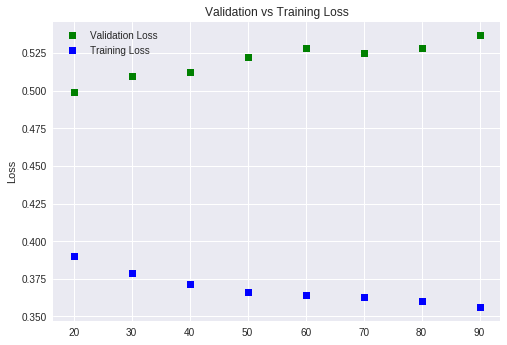

In [0]:
valid_errs = []
train_errs = []
epochs = range(20, 100, 10)


for epc in epochs:
  estimator = KerasRegressor(build_fn=baseline_model, epochs=epc, batch_size=64, verbose=0)
  estimator.fit(train, G_y_train)
  y_pred_tr = estimator.predict(train)
  train_errs.append(metrics.mean_absolute_error(G_y_train, y_pred_tr))
  y_pred_val = estimator.predict(valid)
  valid_errs.append(metrics.mean_absolute_error(G_y_valid, y_pred_val))

  
  
  
plt.plot(epochs, valid_errs, 'gs', epochs, train_errs, 'bs' )
plt
plt.title('Validation vs Training Loss')
plt.ylabel('Loss')
plt.legend(['Validation Loss', 'Training Loss'], loc='upper left')
plt.show()



## Convolutional Neural Network

Size of the convolutions
  - Input is 24 000 x 551

In [0]:
print(train.shape)

(24000, 551)


In [0]:
from sklearn import preprocessing
from keras.layers import Convolution1D, MaxPooling1D, Dropout, LSTM, Dense, Embedding, Flatten
from keras.models import Sequential
from keras import regularizers, optimizers


#TODO: GET RIGHT LAYER SIZES
#TODO: GET RIIGHT OUTPUT LAYER, NOT SOFTMAX
def CNN_model():
  model = Sequential()

  model.add(Convolution1D(100, 40, activation='relu', input_shape=(1, 551)))


  model.add(Dropout(0.5))

  model.add(Conv1D(100, 10, activation='relu'))
  model.add(MaxPooling1D(3))
  
  
  model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.RMSprop(),
    metrics = ['accuracy']
  )
  return model

# fix random seed for reproducibility
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=CNN_model, epochs=100, batch_size=64, verbose=0)

history = estimator.fit(train, G_y_train)

print(history.history)
y_pred_tr = estimator.predict(train)

train_error_prc = MAPE(G_y_train, y_pred_tr)
train_error_abs = metrics.mean_absolute_error(G_y_train, y_pred_tr)
print("Mean percentage train error: {:.2f}%".format(train_error_prc))
print("Mean absolute train error: {:.2f}".format(train_error_abs))

import matplotlib.pyplot as plt

y_pred_val = estimator.predict(valid)

valid_error_prc = MAPE(G_y_valid, y_pred_val)
valid_error_abs = metrics.mean_absolute_error(G_y_valid, y_pred_val)
print("Mean percentage valid error: {:.2f}%".format(valid_error_prc))
print("Mean absolute valid error: {:.2f}".format(valid_error_abs))


plt.plot(history.history['loss'])

plt.title('Model Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['FFN'], loc='upper left')
plt.show()




ValueError: ignored